In [3]:
# Imports
import os
from os.path import join

import numpy as np
import h5py
import hdf5plugin
import tables
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

In [1]:
dirpath = '/home/mattho/data/cmass-ili/borg-quijote/'

In [30]:
fname = join(dirpath, 'latin_hypercube_HR-512', '1981', 'rho.npy')
rho = np.load(fname)

(-0.5, 511.5, 511.5, -0.5)

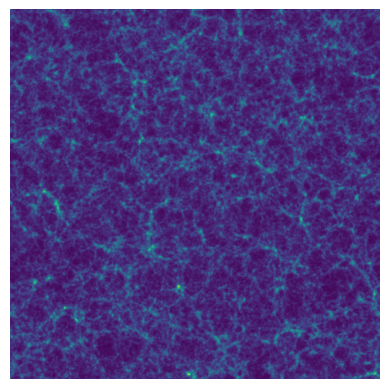

In [31]:
f, ax = plt.subplots()
plt.imshow(np.mean(rho[250:300], axis=0))
ax.axis('off')

# OLD BELOW

In [2]:
dirpath = '/home/mattho/data/quijote/Snapshots/latin_hypercube_HR/0/ICs'

filename = join(dirpath, 'ics.2.hdf5')
with h5py.File(filename, "r") as f:
    print("Keys: %s" % f['PartType1'].keys())
    xyz = np.array(f['PartType1']['Coordinates'])
    ids =  np.array(f['PartType1']['ParticleIDs'])
    vxyz = np.array(f['PartType1']['Velocities'])
    
    # print(xyz[1])
    

Keys: <KeysViewHDF5 ['Coordinates', 'ParticleIDs', 'Velocities']>


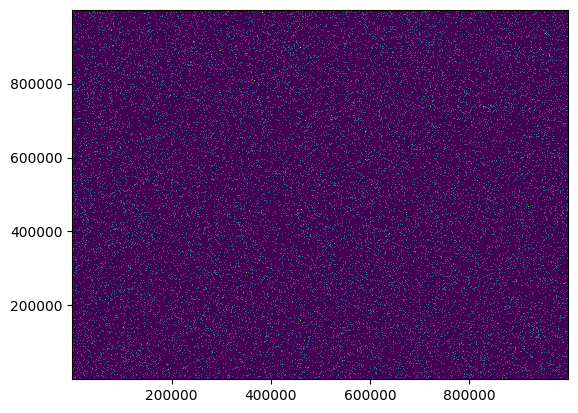

In [22]:
mask = np.random.rand(len(xyz))<0.001
_ = plt.hist2d(xyz.loc[mask,1], xyz.loc[mask,2], 1024)

In [18]:
import nbodykit as nbkt

ModuleNotFoundError: No module named 'nbodykit'

In [4]:
import aquila_borg as borg

# This retrieve the console management object
console = borg.console()
# This prints at the STD level
console.print_std("Hello!")
# Reduce verbosity
console.setVerboseLevel(2)

[0 / 1] [INFO   ] libLSS version c34ba8ab6beacce574fc140d969b0091680192e0 built-in modules Initializing console.

[0 / 1] [STD    ] Using OneAPI/TBB (default scheduler).
[0 / 1] [INFO   ] Registering data IO converters
[0 / 1] [INFO S ] Registered forward models:
[0 / 1] [INFO S ]    2LPT_CIC, 2LPT_CIC_OPENMP, 2LPT_DOUBLE, 2LPT_NGP, ALTAIR_AP, Downgrade
[0 / 1] [INFO S ]    EnforceMass, HADES_LOG, HADES_PT, Haar, LPT_CIC, LPT_CIC_OPENMP, LPT_CIC_TBB
[0 / 1] [INFO S ]    LPT_DOUBLE, LPT_NGP, LPT_NU_CIC, LPT_NU_CIC_OPENMP, PATCH_MODEL, PM_CIC
[0 / 1] [INFO S ]    PM_CIC_OPENMP, PM_CIC_OPENMP2, PM_CIC_TBB, PM_TILE_CIC, PM_TILE_TBB_CIC
[0 / 1] [INFO S ]    PRIMORDIAL, PRIMORDIALV2, PRIMORDIAL_AS, PRIMORDIAL_FNL, QLPT, QLPT_RSD
[0 / 1] [INFO S ]    Softplus, TRANSFER_CLASS, TRANSFER_EHU, TRANSFER_EHUV2, Transfer, Upgrade
[0 / 1] [INFO S ]    bias::BrokenPowerLaw, bias::BrokenPowerLawSigmoid, bias::DoubleBrokenPowerLaw
[0 / 1] [INFO S ]    bias::EFT, bias::EFT_Thresh, bias::Linear, bias::Man

In [17]:
import numpy as np

# Define a physical box (that is optional for this step, but it will be useful later
box = borg.forward.BoxModel()
box.L = (1e3,1e3,1e3)
box.N = (1024,1024,1024)

# Generate gaussian random numbers, Fourier transform them, and rescale to ensure unit-variance
ic = np.fft.rfftn(np.random.randn(*box.N))/box.Ntot**(0.5)

KeyboardInterrupt: 

In [16]:
ic.shape

(128, 128, 65)

In [24]:
vxyz

,0,1,2
0,-614.069275,331.663391,-352.656525
1,-626.644043,333.981598,-374.023193
2,-611.316101,323.954285,-373.052155
3,-614.767578,315.895599,-312.753540
4,-636.730103,297.962158,-321.481415
...,...,...,...
134217723,-668.589966,536.104370,82.511368
134217724,-711.086853,504.362732,45.115910
134217725,-735.532349,487.858032,-2.889538
134217726,-773.023987,515.847046,-51.124752


In [ ]:
df = borg.forward.velocity.computeSICDensityField(
    ids=ids[::10000], positions=xyz[::10000].astype('float64'), 
    L=1000., N=len(xyz[::10000]), Ng=128, max_threads=1)

In [10]:
xyz[::10].shape

(13421773, 3)

In [12]:
len(xyz[::10])

13421773

# genIC

In [39]:
def load_modes(fn):
    """Loading in Fourier space."""
    num_mesh_1d = 512
    num_modes_last_d = num_mesh_1d // 2 + 1
    with open(fn, 'rb') as f :
        num_read = np.fromfile(f, np.uint32, 1)[0]
        modes = np.fromfile(f, np.complex128, num_read).reshape((num_mesh_1d, num_mesh_1d, num_modes_last_d))
    return modes

path_to_wn = '/home/mattho/data/cmass-ili/quijote_ics/wn_1.dat'
s_hat = load_modes(path_to_wn)

FileNotFoundError: [Errno 2] No such file or directory: '/home/mattho/data/cmass-ili/quijote_ics/wn_1.dat'

In [3]:
np.var(s_hat)

0.9962011101572357

In [37]:
import sys
import os
from os.path import join
import time

os.environ["PYBORG_QUIET"] = "yes"

import numpy as np
import borg


cind = 1 # "fid" # 10 # int(sys.argv[1])
L = 1000
N = 512
zi = 127
zf = 0.
supersampling=1

ai = 1/(1+zi)
af = 1/(1+zf)

transfer = 'EH' # 'CLASS' # 


# define fucnctions
def get_params(index):
    if index=="fid":
        return [0.3175, 0.049, 0.6711, 0.9624, 0.834]
    with open('latin_hypercube_params.txt','r') as f:
        content = f.readlines()[index+1]
    content = [np.float64(x) for x in content.split()]
    return content

def build_cosmology(pars):
    cpar = borg.cosmo.CosmologicalParameters()
    cpar.default()
    cpar.omega_m, cpar.omega_b, cpar.h, cpar.n_s, cpar.sigma8 = pars
    return cpar

def transfer_EH(chain, box, cpar):
    chain.addModel(borg.forward.models.Primordial(box, ai))
    chain.addModel(borg.forward.models.EisensteinHu(box))

def transfer_CLASS(chain, box, cpar):
    # not currently used
    sigma8_true = np.copy(cpar.sigma8)
    cpar.sigma8 = 0
    cpar.A_s = 2.3e-9 #will be modified to correspond to correct sigma
    cosmo = borg.cosmo.ClassCosmo(cpar, k_per_decade=10, k_max=50, extra={'YHe':'0.24'})
    cosmo.computeSigma8() #will compute sigma for the provided A_s
    cos = cosmo.getCosmology()
    # Update A_s
    cpar.A_s = (sigma8_true/cos['sigma_8'])**2*cpar.A_s
    chain.addModel(borg.forward.model_lib.M_PRIMORDIAL_AS(box)) # Add primordial fluctuations
    transfer_class=borg.forward.model_lib.M_TRANSFER_CLASS(box,opts={"a_transfer":ai,"use_class_sign":False}) # Add CLASS transfer function
    transfer_class.setModelParams({"extra_class_arguments":{"YHe":"0.24","z_max_pk":"200"}})
    chain.addModel(transfer_class)
    
def run_density(cpar, ic):
    # initialize box and chain
    box = borg.forward.BoxModel()
    box.L = (L,L,L)
    box.N = (N,N,N)

    chain = borg.forward.ChainForwardModel(box)
    chain.addModel(borg.forward.models.HermiticEnforcer(box))

    if transfer=='CLASS':
        transfer_CLASS(chain, box, cpar)
    elif transfer=='EH':
        transfer_EH(chain, box, cpar)

    # add lpt
    lpt = borg.forward.models.Borg2Lpt(
        box=box, box_out=box, 
        ai=ai, af=af, 
        supersampling=supersampling
    )
    chain.addModel(lpt)
    chain.setCosmoParams(cpar)

    # forward model
    # ic = np.fft.rfftn(np.random.randn(*box.N))/box.Ntot**(0.5)
    chain.forwardModel_v2(ic)
    
    Npart = lpt.getNumberOfParticles()
    rho = np.empty(chain.getOutputBoxModel().N)
    pos = np.empty(shape=(Npart,3))
    vel = np.empty(shape=(Npart,3))
    
    chain.getDensityFinal(rho)
    lpt.getParticlePositions(pos)
    lpt.getParticleVelocities(vel)
    
    return rho, pos, vel


# Set up cosmo
content = get_params(cind)
print(content)

[0.21390000000000003, 0.05557000000000001, 0.8599000000000001, 0.9785, 0.8618999999999999]


In [5]:
cpar = build_cosmology(content)

In [ ]:
rho, pos, vel = run_density(cpar, s_hat)

In [10]:
fname = '/home/mattho/data/quijote/3D_Cubes/latin_hypercube_HR/0/df_m_512_PCS_z=0.npy'
x = np.load(fname)

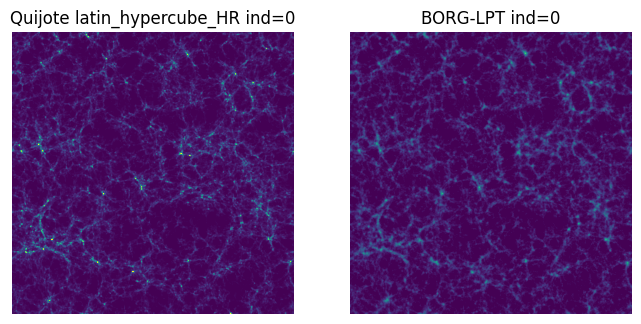

In [21]:
f, axs = plt.subplots(1,2, figsize=(8,4))


axs[0].imshow(np.mean(x[300:325], axis=0), vmin=-0.5, vmax=10)
axs[0].axis('off')
axs[0].set_title('Quijote latin_hypercube_HR ind=0')

axs[1].imshow(np.mean(rho[300:325], axis=0), vmin=-0.5, vmax=10)
axs[1].axis('off')
axs[1].set_title('BORG-LPT ind=0')

# f.savefig('images/qui-borg_compare.jpg', dpi=400, bbox_inches='tight')

In [38]:
get_params(1)

[0.21390000000000003,
 0.05557000000000001,
 0.8599000000000001,
 0.9785,
 0.8618999999999999]

# pick Quijote

In [1]:
import pandas as pd

In [4]:
par = pd.read_csv('latin_hypercube_params.txt', delimiter=' ', skipinitialspace=True)

(0.6001, 0.9999)

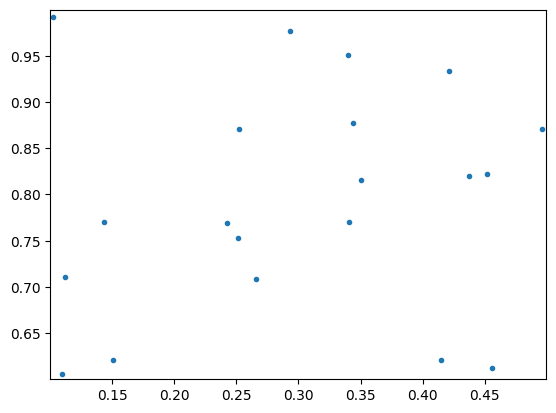

In [24]:
# inds = np.random.choice(len(par), size=20, replace=False)
inds = [  88,  590,  886, 1580,   98,  846,  823,    4, 1318, 1088, 1981,
        233, 1451, 1901,  949, 1433, 1290, 1233,  894, 1575]

plt.plot(par.loc[inds,'#Omega_m'], par.loc[inds,'sigma_8'],'.')
plt.xlim(par['#Omega_m'].min(), par['#Omega_m'].max())
plt.ylim(par['sigma_8'].min(), par['sigma_8'].max())

In [25]:
inds = [str(x) for x in np.sort(inds)]
' '.join(inds)

'4 88 98 233 590 823 846 886 894 949 1088 1233 1290 1318 1433 1451 1575 1580 1901 1981'

In [23]:
inds

array([  88,  590,  886, 1580,   98,  846,  823,    4, 1318, 1088, 1981,
        233, 1451, 1901,  949, 1433, 1290, 1233,  894, 1575])